In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import ase
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import abtem

abtem.config.set({"local_diagnostics.progress_bar": True});

(tutorial:visualizations)=
# Visualizations

Visualizing the results is an integral part of understanding the output of a scattering simulation. The *ab*TEM visualization module wraps the `matplotlib` library to produce typical visualizations needed when simulating electron microscopy, in this tutorial we cover how to customize visualizations the standard *ab*TEM publications to publication-ready visualizations. We note that not every customization is possible within our framework; it may sometimes be more practical to create your own visualization from scratch.

```{seealso}
This tutorial only covers static visualizations. The *ab*TEM visulization module also features [animated](tutorial:animations) and [interactive](tutorial:interactions) visualizations, see the respective tutorials for more information.
```

## Customizing an image ensemble

The *ab*TEM visualization module is based on the concept of ensembles of similar measuremenst. Given an object with one or more ensemble axes *ab*TEM can create an "exploded" plot when you set `explode=True`. The exploded plot shows a 1D or 2D grid of images or line plots, where each image or line plot represents a member in the ensemble.

We create HRTEM images for silicon $\{100\}$ with a single ensemble dimension representing different values of defocus.

In [4]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 100)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=100e3)

defocus = np.linspace(-80, 80, 5)

measurements = (
    wave.multislice(potential)
    .apply_ctf(defocus=defocus, Cs=10e6, semiangle_cutoff=20, focal_spread=30)
    .intensity()
    .tile((3, 3))
    .poisson_noise(dose_per_area=2e3, seed=100)
    .compute()
)

[########################################] | 100% Completed | 3.84 ss


We create a visualization using the `.show` method and set `explode=True` to create an "exploded" grid plot. We set `common_color_scale=True` to show all the images on a single color scale, if this is set to `False` each image is scaled indepdently. We set `cbar=True` to included a colorbar and `cmap="gray"` to show the images using a grayscale colormap, see the `matplotlib` [documentation](https://matplotlib.org/stable/gallery/color/colormap_reference.html) for a full list of colormaps. 

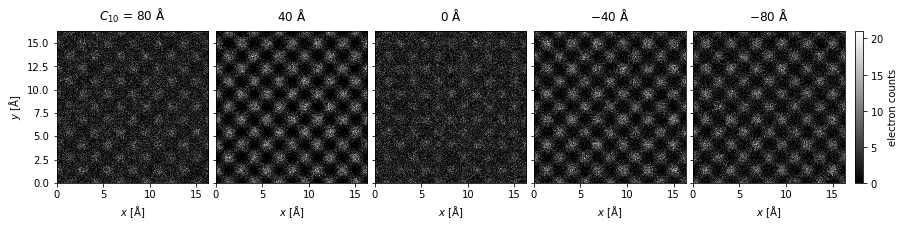

In [5]:
visualization = measurements.show(
    explode=True,
    common_color_scale=True,
    figsize=(14, 5),
    cbar=True,
    cmap="gray",
)

The `.show` method produces a `MeasurementVisualization` object, the specific subtype will depend on the type of measurement used to create the visualization. In this case, we obtain a `MeasurementVisualization2D` object. The `MeasurementVisualization` objects wraps a matplotlib figure.

In [6]:
object.__repr__(visualization.fig)

'<matplotlib.figure.Figure object at 0x00000194854EA500>'

The plots are laid out using the `AxesGrid` class.

In [7]:
visualization.axes

We can convert the `AxesGrid` to a `numpy` array of `matplotlib` `Axes` as below. The `numpy` array is always 2D, hence in this case it is a `(3,1)` array, where the first dimension indexes columns.

In [8]:
np.array(visualization.axes)

array([[<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>],
       [<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>],
       [<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>],
       [<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>],
       [<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>]],
      dtype=object)

Each `Axes` can be adjusted using the methods from `matplotlib`, however, the *abTEM* `MeasurementVisualization` implements some methods to assist convert the standard *ab*TEM figure to something more apporpriate for a publication.

We can adjust the vertical and horisontal spacing betwen images using the `.set_axes_padding` method, in our case we only need to adjust the horizontal spacing. The width of the colorbar can be adjusted using the `.set_cbar_size` method, finally we can adjust the left and right padding of the colorbar using the `.set_cbar_padding` method.

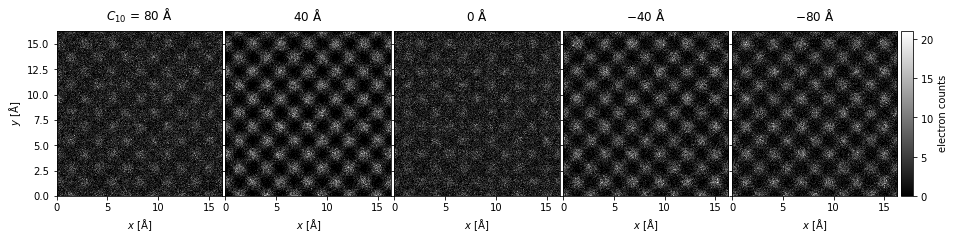

In [9]:
visualization.set_axes_padding((0.05, 0.0))
visualization.set_cbar_size(0.075)
visualization.set_cbar_padding((0.05, 0.0))

visualization.fig

We can change the units of the titles using the `.set_column_titles` method, the units of the $x$ and $y$-axis can also be changed by using the `set_x_units` or `set_y_units` methods.

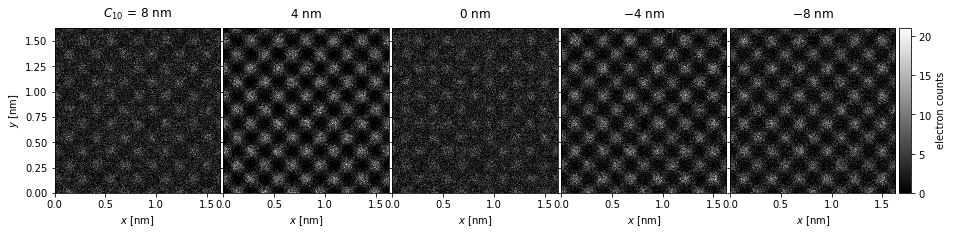

In [8]:
visualization.set_column_titles(units="nm")
visualization.set_x_units("nm")
visualization.set_y_units("nm")

visualization.fig

We can remove the titles by setting them to an empty string.

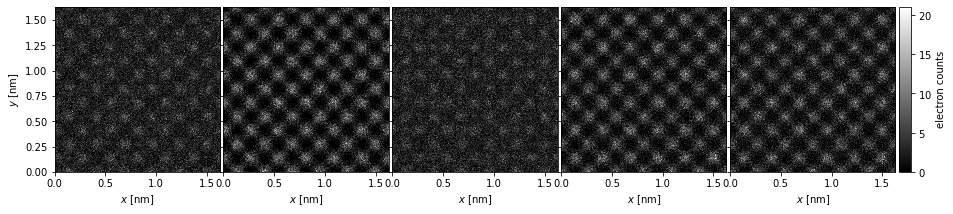

In [9]:
visualization.set_column_titles(titles="")

visualization.fig

The axes ticks and labels can be removed using the `axis_off` method. We can add a sizebar to preserve a description of the scale.

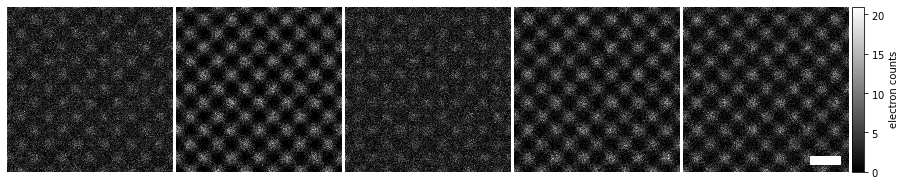

In [10]:
visualization.axis_off(spines=False)
visualization.set_sizebars(size=3, color="w")

visualization.fig

Finally, we can label each image using the same metadata used for the standard titles to add annotations.

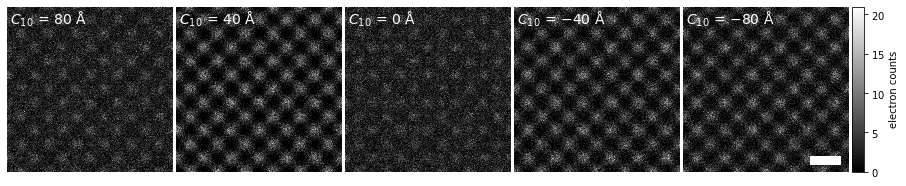

In [11]:
visualization.set_panel_labels(
    labels="metadata", frameon=False, prop={"fontsize": 14, "color": "w"}
)

visualization.fig

## 2D ensemble of images

In the next example, we demonstrate a 2D grid of graphene images for different values of defocus and spherical aberrations.

In [12]:
defocus = np.linspace(-50, 50, 7)
Cs = np.linspace(0, 400000, 5)
focal_spread = 30

atoms = ase.build.graphene(vacuum=2)

exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(atoms)

images = (
    exit_wave.apply_ctf(defocus=defocus, Cs=Cs, focal_spread=focal_spread)
    .intensity()
    .poisson_noise(5e5)
    .compute()
)

[########################################] | 100% Completed | 350.63 ms


We create a 2D grid of images on the same color scale by setting `explode=True` and `common_color_scale=True`.

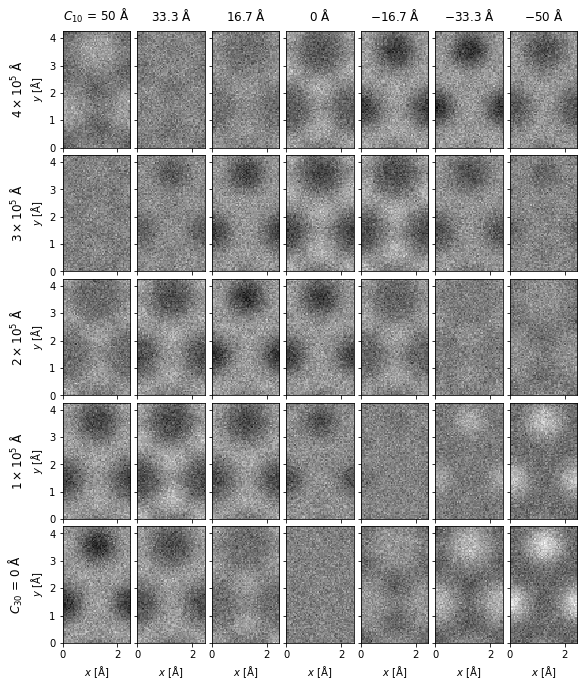

In [13]:
visualization = images.show(
    explode=True, figsize=(10, 10), common_color_scale=True, cmap="gray"
)

We can remove the spacing between the images using the `set_axes_padding` method. The axes desciptions can be removed using the `axis_off` method, and we can instead add a scalebar using the `set_sizebar` method.

In [14]:
visualization.set_axes_padding([0.0, 0.0])
visualization.axis_off(spines=False)

visualization.set_sizebars(size=1, color="w")

We can change the units displayed in the titles using the `set_row_titles` and `set_column_titles` methods.

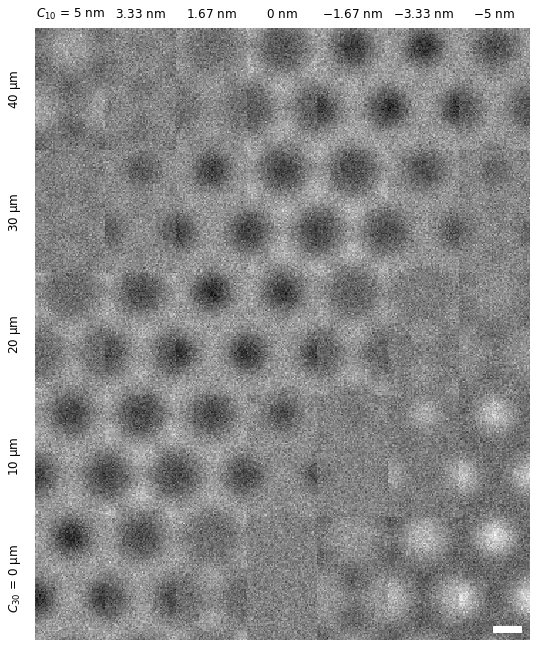

In [15]:
visualization.set_row_titles(units="um")
visualization.set_column_titles(units="nm")

visualization.fig

## Diffraction spots

The diffraction intensities calculated using a multislice simulation are concentrated in single pixels, which does not naturally produce nice visualizations. Using the indexing algorithm we can get the position and intensity of the diffraction spots which can be visualized as disks. In the example below we create the typical textbook display of electron diffraction patterns for SiO<sub>2</sub> Zeolite where each diffraction spot is a white disk on a black background.

In [16]:
atoms_cell = ase.io.read("data/SiO2_zeolite.cif")

atoms = atoms_cell * (1, 1, 10)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

wave.grid.match(potential)

measurements = wave.multislice(potential).compute()

spots = measurements.diffraction_patterns().index_diffraction_spots(
    cell=atoms_cell.cell, threshold=1e-4
)

[########################################] | 100% Completed | 2.61 ss


We create the visualization cropping the maximum scattering angle to $10 \ \mathrm{mrad}$, we block the direct bea, and set the colormap to solid white.

In [17]:
visualization = (
    spots.crop(10)
    .block_direct()
    .show(
        figsize=(8, 8),
        scale=0.5,
        cmap="w",
        display=False,
    )
)

We can access our `matplotlib` `Axes` and apply the method for setting the background color as below.

In [18]:
visualization.axes[0, 0].set_facecolor("k")

To avoid too much cluttering we set a threshold for what diffraction spots are labelled with miller indices to an intensity of $0.0003$ (the full intensity including the direct beam should sum around $1.0$, ).

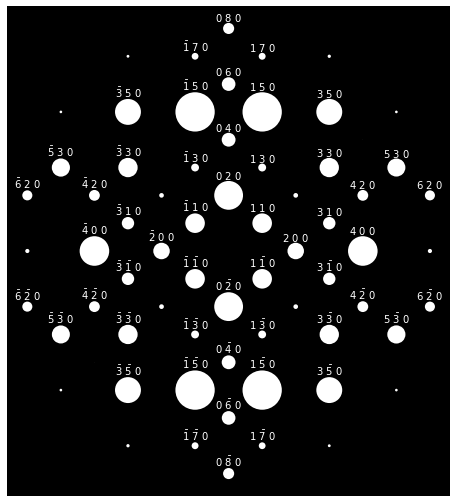

In [19]:
visualization.axis_off(spines=False)

visualization.set_miller_index_annotations(0.0003, size=10, color="w")

visualization.fig

## Domain coloring

The phase and amplitude can be displayed simultaneously using a technique called [domain coloring](https://en.wikipedia.org/wiki/Domain_coloring).

In [20]:
probe = abtem.Probe(
    semiangle_cutoff=30,
    defocus=60,
    astigmatism=np.linspace(0, 70, 3),
    astigmatism_angle=np.pi / 4,
    gpts=256,
    extent=10,
    energy=200e3,
)
probes = probe.build().complex_images().compute()

[########################################] | 100% Completed | 114.15 ms


By default, we map the phase to colors using the ["HSLuv"](https://www.hsluv.org/) color mapping, however; the more saturated ["hsv"/"hsl"](https://en.wikipedia.org/wiki/HSL_and_HSV) mapping is also available by setting `cmap=hsv`.

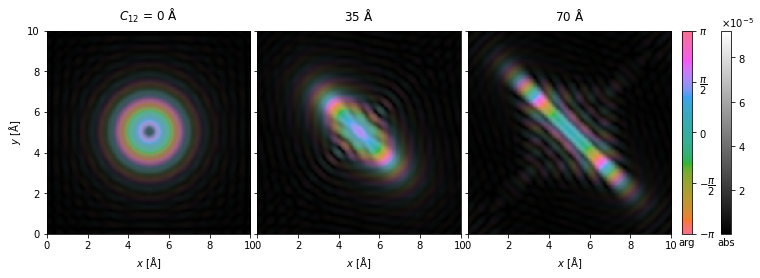

In [21]:
visualization = probes.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsluv"
)